In [1]:
# Copyright (C) 2023 qBraid
# Copyright (C) IBM
#
# This file is part of the qBraid-SDK.
#
# The qBraid-SDK is free software released under the GNU General Public License v3
# or later. This specific file, adapted from Qiskit, is dual-licensed under both the
# Apache License, Version 2.0, and the GPL v3. You may not use this file except in
# compliance with the applicable license. You may obtain a copy of the Apache License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file includes code adapted from Qiskit (https://github.com/Qiskit/qiskit-ibm-provider)
# with modifications by qBraid. The original copyright notice is included above.
# THERE IS NO WARRANTY for the qBraid-SDK, as per Section 15 of the GPL v3.

# qBraid-SDK IBM Batch Jobs Demo: Grover's Algorithm


Per usual, install the qBraid SDK environment on Lab, and use the qBraid CLI to enable [Quantum Jobs](https://docs.qbraid.com/en/latest/lab/quantumjobs.html):

In [2]:
!qbraid jobs enable qbraid_sdk

You have already enabled qBraid Quantum Jobs in the qbraid_sdk environment.


You can check that the `jobs` keyword next to the qBraid SDK environment is now green.

In [3]:
!qbraid envs list

# installed environments:
#
default                  jobs  /opt/.qbraid/environments/qbraid_000000
aws_braket               jobs  /home/jovyan/.qbraid/environments/aws_braket_kwx6dl
qbraid_sdk               jobs  /home/jovyan/.qbraid/environments/qbraid_sdk_9j9sjy



It's important to import the qBraid SDK only *after* you have enabled quantum jobs.

In [4]:
import qbraid

qbraid.__version__

'0.4.4.dev20230816194153'

## Creating the Circuits

In [5]:
from qiskit import QuantumCircuit
from numpy import random
import matplotlib.pyplot as plt

The code for this circuit was taken from IBMs [Qiskit Textbook](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm). Grover's algorithm let's us find a marked item in a box in √N steps as opposed to N steps classicaly. In this case we'll run Grover's algorithm for various numbers of steps to observe how the performance varies. This will allow us to test qBraid's [run_batch](https://github.com/qBraid/qBraid/blob/6e6cecc3ec4b7bac973f557606778d2cd07b8307/qbraid/devices/ibm/device.py#L111) functionality.

In [6]:
n = 3
marked_entry = random.randint(0, 2**n - 1)
print("marked entry: ", marked_entry)

marked entry:  6


In [7]:
Vf = QuantumCircuit(n, n)

Uw = []
for i in range(2**n):
    if i == marked_entry:
        Uw.append(-1)
    else:
        Uw.append(1)
Vf.diagonal(Uw, [0, 1, 2])


# Diffuser from the Qiskit Textbook
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
    qc.h(nqubits - 1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s


W = QuantumCircuit(n, n)
W.append(diffuser(n), range(n))
VW = Vf.compose(W)

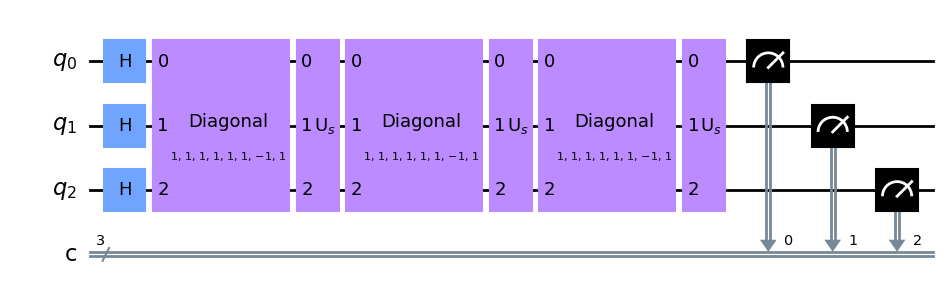

In [8]:
# create list of circuits to run
n_steps = 3
grover_init = QuantumCircuit(VW.num_qubits, VW.num_clbits)
grover_init.h(range(n))  # add the Hadamards
circuits = [grover_init]  # circuits[j] will have (VW)**j:
for _ in range(n_steps):
    circuits.append(circuits[-1].compose(VW))
for grover in circuits:
    grover.measure(range(n), range(n))  # add measurements

circuits[3].draw("mpl")

Now that we've created our Grover circuit for n = 0, 1, 2, and 3, we can simply pass the `circuits` array

# Running the Circuits

First, let's check how many credits we have left

In [9]:
!qbraid jobs get-credits

You have 1000.00 remaining qBraid credits.


We can also check which devices are online:

In [10]:
from qbraid import get_devices

In [11]:
get_devices(filters={"vendor": "IBM"})

Provider,Name,qBraid ID,Status
AWS,DM1,aws_dm_sim,●
AWS,SV1,aws_sv_sim,●
AWS,TN1,aws_tn_sim,●
IBM,Belem,ibm_q_belem,●
IBM,Ext. stabilizer simulator,ibm_q_simulator_extended_stabilizer,●
IBM,Jakarta,ibm_q_jakarta,●
IBM,Lagos,ibm_q_lagos,○
IBM,Lima,ibm_q_lima,●
IBM,MPS simulator,ibm_q_simulator_mps,●
IBM,Manila,ibm_q_manila,●


Now let's load in our IBM account:

In [12]:
# from qiskit_ibm_provider import IBMProvider

# from qbraid.devices.ibm import ibm_provider

# QISKIT_IBM_TOKEN = 'cd1bef0497104335291e1ef5af70f7309540392f0a1e58cecd1844753d4567d46e54ad41f3cecfee19e4edca185162177046b12cb1a3d1e3d7f2d92154ea331b'
# provider = ibm_provider(token=QISKIT_IBM_TOKEN)

In this tutorial we'll use IBM's Lima computer, since we see that it's online. Now we can use qBraid's [device wrapper](https://docs.qbraid.com/en/latest/sdk/devices.html#device-wrapper) to run this job. The device wrapper adds a layer of abstraction, allowing us to run more types of circuits on more devices, and in this case letting us use the `run_batch` method. 

In [13]:
from qbraid import device_wrapper

device = device_wrapper("ibm_q_lima")
job = device.run_batch(circuits, shots=100)

In [14]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [ ]:
result = job.result()
counts = result.measurement_counts()

In [ ]:
for circ in counts:
    print circ

We see that our results line up roughly with the theoretical prediction in the xtebook. With 0 grover steps, the probability is basically evenly distributed. At one step, we see it is roughly 80% correct, as we expect. The probability then peaks at 2 steps and dips again at 3 steps.